In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import sys
sys.path.append("../../../../")
import src

from src.core.control import AfPrecisionControl
from src.core.control import CoupledStorageConfig

from src.core.dimensionless import WavevectorScale, Dimensional, LatticeScale

from src.core.media import TwoBeamPhotorefractiveCrystal
from src.core.eq_coefs import CoupledPhotorefractiveCoefs
from src.core.mesh import Mesh2D
from src.core.beams import TwoBeams

from src.fields import NotebookAfCoupledSimulation2D
from src.fields import LatticeGaussianCoupledConfig

from src.fields.landscapes.lattices.moire_lattices import double_square
from src.simulators.nls_2d.coupled_eqs.split_step import split_step_solver

from src.simulators.nls_2d.coupled_eqs import CoupledSimulationBox

In [3]:
periodic_storage = CoupledStorageConfig(directory = "./Data/Periodic/",
                                    store = "last",
                                    extension = ".h5",
                                    )

aperiodic_storage = CoupledStorageConfig(directory = "./Data/Aperiodic/",
                                    store = "last",
                                    extension = ".h5",
                                    )

In [4]:
precision = "double"

periodic_precision = AfPrecisionControl(precision=precision,
                                       store_config=periodic_storage,
                                       )

aperiodic_precision = AfPrecisionControl(precision=precision,
                                       store_config=aperiodic_storage,
                                       )

In [5]:
simulation_config = {"Nx": 1024,
                     "Ny": 1024,
                     "Nz": 200,
                     "lx": 1.5*1e-3,
                     "ly": 1.5*1e-3,
                     "lz": 20e-3,
                     }

Isat = 7.5

periodic_crystal_parameters = TwoBeamPhotorefractiveCrystal(n = 2.36,#2.36,
                                                   n1 = 2.36,#2.36,
                                                   electro_optic_coef = 250e-12,#235e-12,
                                                   electro_optic_coef1 = 250e-12,#235e-12,
                                                   tension = 400,
                                                   Isat = Isat,#b * 1e-13,
                                                   alpha = 0.,
                                                   alpha1 = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   store_config=periodic_storage,
                                                   )

aperiodic_crystal_parameters = TwoBeamPhotorefractiveCrystal(n = 2.36,
                                                   n1 = 2.36,
                                                   electro_optic_coef = 250e-12,
                                                   electro_optic_coef1 = 250e-12,
                                                   tension = 400,
                                                   Isat = Isat,#b * 1e-13,
                                                   alpha = 0.,
                                                   alpha1 = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   store_config=aperiodic_storage,
                                                   )

periodic_crystal_parameters.delta_n_max, aperiodic_crystal_parameters.delta_n_max

(0.00013144256, 0.00013144256)

In [6]:
sign = -1.

periodic_beam_parameters = TwoBeams(wavelengths = (633e-9, 532e-9),
                             cs = (sign * 1., sign * .1),
                             store_config = periodic_storage,
                             )

aperiodic_beam_parameters = TwoBeams(wavelengths = (633e-9, 532e-9),
                             cs = (sign * 1., sign * .1),
                             store_config = aperiodic_storage,
                             )

periodic_beam_parameters.wavelength, aperiodic_beam_parameters.wavelength1

(6.33e-07, 5.32e-07)

In [7]:
periodic_theta = np.atan(3/4)
# periodic_theta = np.atan(5/12)
periodic_eta = 0*45*np.pi/180 + 0*.5*(.5*np.pi - periodic_theta)

I = .3
I1 = 16 * Isat

a_sublattice = 20e-6#20e-6
state_waist = 11.5e-6
lattice_waist = 600e-6

periodic_modulation_properties = LatticeGaussianCoupledConfig(lattice_parameter=None,
                                                lattice1_parameter=(a_sublattice, a_sublattice),
                                                p=None,
                                                p1=(1., 1.),
                                                rotation=None,
                                                rotation1=(periodic_eta, periodic_theta+periodic_eta),
                                                width=(state_waist, state_waist),
                                                width1=(lattice_waist, lattice_waist),
                                                center = (0*50e-6, -0*10.e-6),
                                                I = I,#a * 1.5e-14 * state_i,
                                                I1 = I1,#a * 2e-6 * lattice_i,
                                                power=1.,
                                                power1=4.,
                                                store_config=periodic_storage,
                                                lattice_method=None,
                                                lattice1_method=double_square,
                                                )

aperiodic_theta = np.atan(1/np.sqrt(3))
aperiodic_eta = 0*45*np.pi/180 + 0*.5*(.5*np.pi - aperiodic_theta)
aperiodic_modulation_properties = LatticeGaussianCoupledConfig(lattice_parameter=None,
                                                lattice1_parameter=(a_sublattice, a_sublattice),
                                                p=None,
                                                p1=(1., 1.),
                                                rotation=None,
                                                rotation1=(aperiodic_eta, aperiodic_theta+aperiodic_eta),
                                                width=(state_waist, state_waist),
                                                width1=(lattice_waist, lattice_waist),
                                                center = (0*50e-6, -0*10.e-6),
                                                I = I,#a * 1.5e-13 * state_i,
                                                I1 = I1,#a * 2e-6 * lattice_i,
                                                power=1.,
                                                power1=4.,
                                                store_config=aperiodic_storage,
                                                lattice_method=None,
                                                lattice1_method=double_square,
                                                )

Lattice parameters on the first beam are not defined.
Lattice parameters on the first beam are not defined.


In [8]:
# periodic_adim_method = WavevectorScale(periodic_beam_parameters, periodic_crystal_parameters, periodic_precision)
# aperiodic_adim_method = WavevectorScale(aperiodic_beam_parameters, aperiodic_crystal_parameters, aperiodic_precision)

# periodic_adim_method = Dimensional()
# aperiodic_adim_method = Dimensional()

periodic_adim_method = LatticeScale(lattice_parameters = periodic_modulation_properties,
                                    beam_parameters = periodic_beam_parameters,
                                    crystal_parameters = periodic_crystal_parameters,
                                    )
aperiodic_adim_method = LatticeScale(lattice_parameters = aperiodic_modulation_properties,
                                    beam_parameters = aperiodic_beam_parameters,
                                    crystal_parameters = aperiodic_crystal_parameters,
                                    )

In [9]:
solver = split_step_solver

In [10]:
periodic_coefs = CoupledPhotorefractiveCoefs(periodic_crystal_parameters,
                                    periodic_beam_parameters,
                                    periodic_adim_method,
                                    periodic_storage,
                                    # invert_energy_scale=True,
                                    )

aperiodic_coefs = CoupledPhotorefractiveCoefs(aperiodic_crystal_parameters,
                                    aperiodic_beam_parameters,
                                    aperiodic_adim_method,
                                    aperiodic_storage,
                                    # invert_energy_scale=True,
                                    )

periodic_coefs.print_coefs()
aperiodic_coefs.print_coefs()

Kinetic: -0.5, Potential: -12.225322370428243, Absorption: 0.0
Kinetic1: -0.42022116903633494, Potential1: -1.454629522646819, Absorption1: 0.0
Kinetic: -0.5, Potential: -12.225322370428243, Absorption: 0.0
Kinetic1: -0.42022116903633494, Potential1: -1.454629522646819, Absorption1: 0.0


In [11]:
periodic_mesh = Mesh2D(simulation_config, periodic_adim_method)
aperiodic_mesh = Mesh2D(simulation_config, aperiodic_adim_method)

periodic_SimBox = CoupledSimulationBox(mesh=periodic_mesh,
                              coefs=periodic_coefs,
                              solver_method=solver,
                              precision_control=periodic_precision,
                              device=0,
                              gpu_backend="cuda",
                              )
aperiodic_SimBox = CoupledSimulationBox(mesh=aperiodic_mesh,
                              coefs=aperiodic_coefs,
                              solver_method=solver,
                              precision_control=aperiodic_precision,
                              device=0,
                              gpu_backend="cuda",
                              )

periodic_mesh.lx, .5*simulation_config["lx"]/simulation_config["Nx"]

(75.0, 7.32421875e-07)

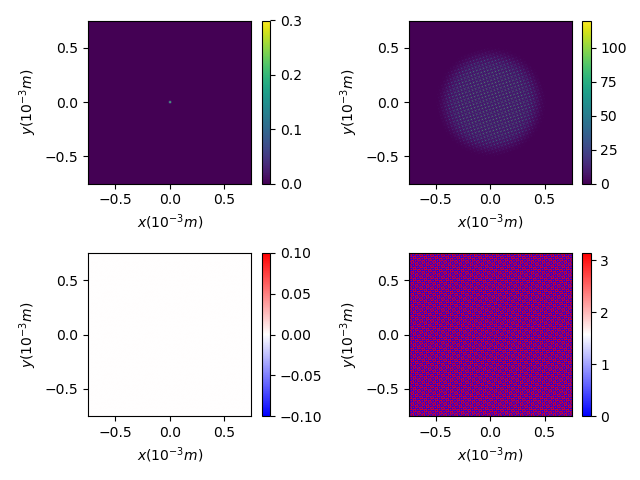

In [12]:
periodic_input_fields = NotebookAfCoupledSimulation2D(simulation_config,
                           modulation_config=periodic_modulation_properties,
                           precision_control=periodic_precision,
                           store_config=periodic_storage,
                           )

periodic_input_fields.gen_fields(periodic_mesh,)

field_tmp = np.copy(periodic_input_fields.field1) 

periodic_input_fields.plot_fields()

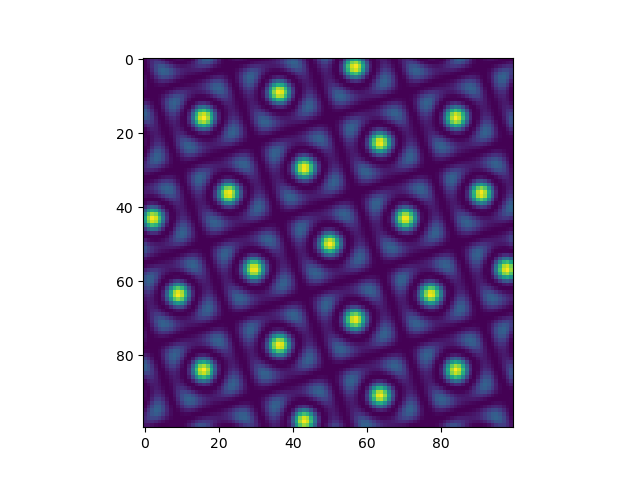

np.float64(14.848004075392705)

In [13]:
lattice = np.abs(periodic_input_fields.field1)**2

mid_x = int(lattice.shape[0]/2)
mid_y = int(lattice.shape[1]/2)

m = 50

fig, axs = plt.subplots(1)
axs.imshow(lattice[mid_x-m:mid_x+m, mid_y-m:mid_y+m])
# axs.imshow(lattice)

fig.show()

# np.sum(lattice*periodic_mesh.adim_method.dimensionalize_length(periodic_mesh.dx)**2)/(.5*np.pi*(600e-4)**2)

np.mean(lattice[mid_x-m:mid_x+m, mid_y-m:mid_y+m])

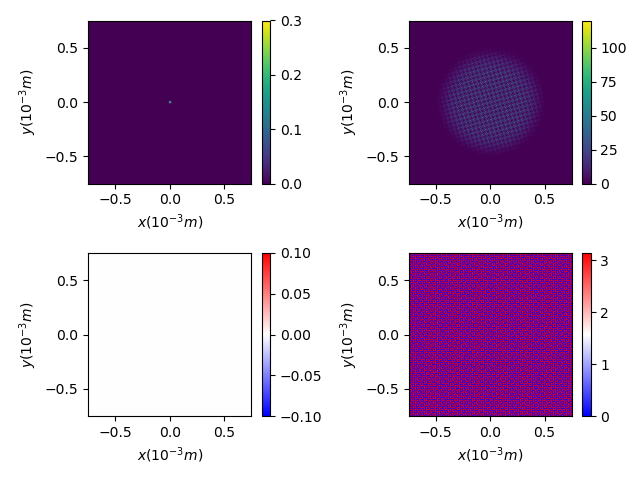

In [14]:
aperiodic_input_fields = NotebookAfCoupledSimulation2D(simulation_config,
                           modulation_config=aperiodic_modulation_properties,
                           precision_control=aperiodic_precision,
                           store_config=aperiodic_storage,
                           )

aperiodic_input_fields.gen_fields(aperiodic_mesh,)

field_tmp = np.copy(aperiodic_input_fields.field1) 

aperiodic_input_fields.plot_fields()

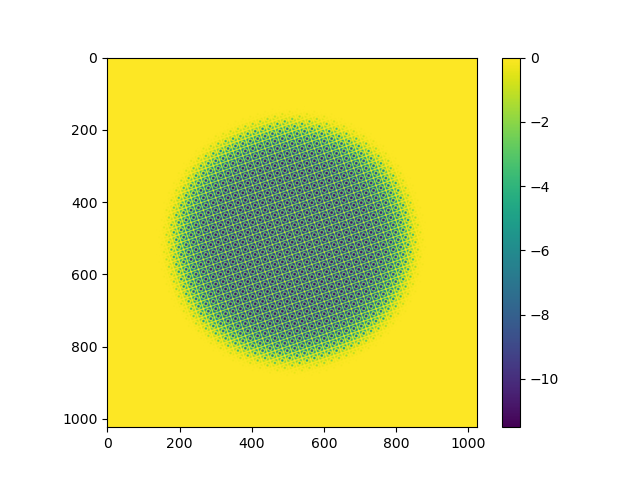

-3.4291624334414372
11.507873874511093


In [15]:
potential = periodic_coefs.potential_function(periodic_input_fields)

fig, axs = plt.subplots(1)
im = axs.imshow(potential)

fig.colorbar(im, ax=axs)

fig.show()

print(potential[mid_x, mid_y]-potential[mid_x+7, mid_y+7])
print(potential.max()-potential.min())

In [16]:
periodic_SimBox.solver(periodic_input_fields, store_config=periodic_storage)

aperiodic_SimBox.solver(aperiodic_input_fields, store_config=aperiodic_storage)

e:\Vicente Rocha\PhD Thesis Project\Photonic-Crystals (worktree)\stable\Studies\PhotorefractiveCrystals\Localization in Moire Lattices\Simulations\../../../..\src\fields\field_plotting.py:443: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


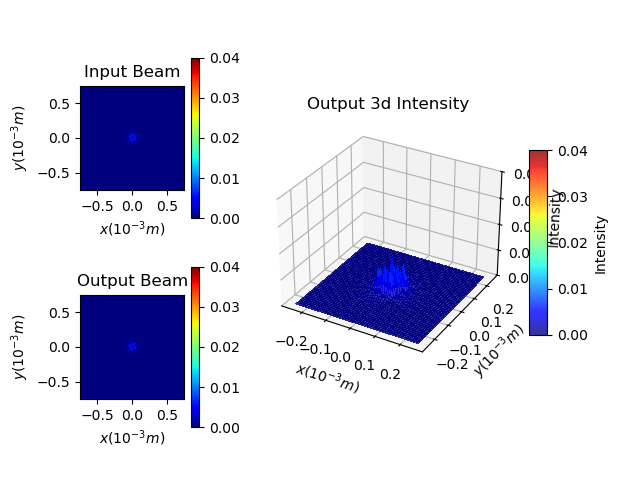

In [17]:
tlim = .25e-3
zlim = np.max((np.max(np.abs(aperiodic_input_fields.field)**2), np.max(np.abs(periodic_input_fields.field)**2)))
zlim = (0, 0.04)

periodic_input_fields.plot_IO_3d(zlim=zlim, scientific_notation_power=-3, xylim=[-tlim, tlim, -tlim, tlim], link_zlim_vmax=True, cmap_2d="jet", cmap_3d="jet")#, savefig="./periodic atan(3_4) p2_1.png",)

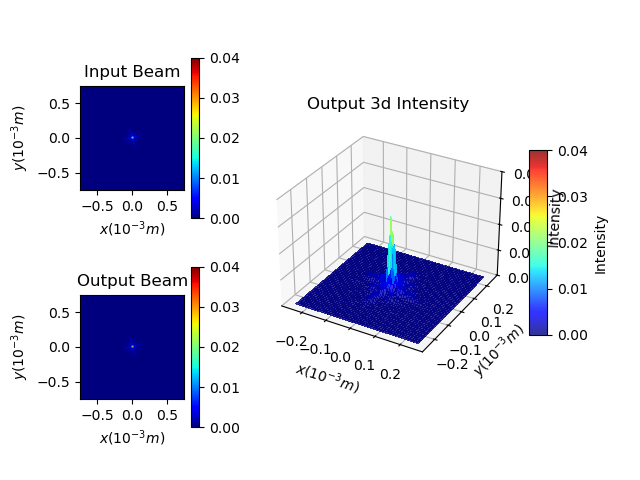

In [18]:
aperiodic_input_fields.plot_IO_3d(zlim=zlim, scientific_notation_power=-3, xylim=[-tlim, tlim, -tlim, tlim], link_zlim_vmax=True, cmap_2d="jet", cmap_3d="jet")#, savefig="./aperiodic atan(1_sqrt(3)) p2_1.png")

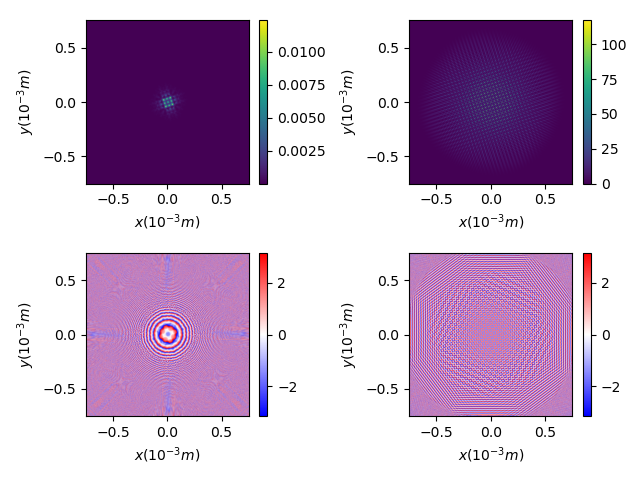

In [19]:
periodic_input_fields.plot_fields()

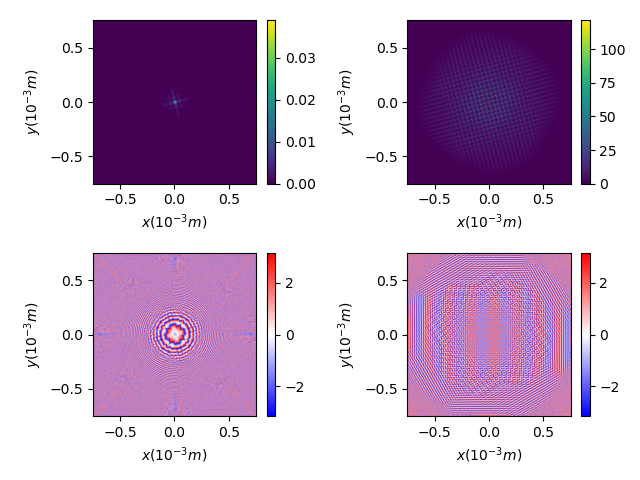

In [20]:
aperiodic_input_fields.plot_fields()